In [14]:
import sys
sys.path.append('..')
import ugent

In [15]:
from schrodinger import Schrodinger2D, Rectangle, Circle
import numpy as np
import math

best_known = 2*np.array([0.99859477260462, 1.99007676008316, 1.99007676008316, 2.95624298898781, 2.98532642806441, 2.98532642806442, 3.92596372109113, 3.92596372109114, 3.98241728327456, 3.98576092607719, 4.87014400547251, 4.89864420444642, 4.89864420444642, 4.98625101494171, 4.98625101494172, 5.81701909971053, 5.81701909971054, 5.86701480916528, 5.88144609873667, 5.99132695571450, 5.99132695571450, 6.73791623075037, 6.76486656303911, 6.76486656303911, 6.85343062732831, 6.85343062732831, 6.99893192820090, 6.99938690825129, 7.65948550690946, 7.65948550690947, 7.69772136553152, 7.73688473693607, 7.83273518682762, 7.83273518682763, 8.00942477463143, 8.00942477463144, 8.55402322299586, 8.57635148658287, 8.57635148658294, 8.67792887113521, 8.67792887113523, 8.81132713081544, 8.81518847088363, 9.02172330707064, 9.02172330707064, 9.44405461567860])
mults = [1]
for i in range(1, len(best_known)):
    if abs(best_known[i] - best_known[i-1])/best_known[i] < 1e-10:
        mults[-1] += 1
    else:
        mults.append(1)

def V(x, y):
    return x*x+y*y+1/6/math.sqrt(5)*y*(3*x*x-y*y)

s = Schrodinger2D(V, Rectangle(-5,5, -5,5),
                  gridSize=(64, 64), maxBasisSize=32)


s.eigenvalues(30, shiftInvert=True)[:21]

[1.9971895472219208,
 3.9801535457929766,
 3.980153635240063,
 5.912488142012863,
 5.970653068809589,
 5.970654937837548,
 7.851938116694955,
 7.85197780095867,
 7.964855180235981,
 7.971524305990256,
 9.740650438105897,
 9.79734431538006,
 9.797769735903088,
 9.972541185359907,
 9.972605407677522,
 11.635041038963521,
 11.638134639587044,
 11.736655493607074,
 11.763285763433391,
 11.982822565232935,
 11.983195899887304]

In [16]:
from p_tqdm import p_map

    
def test_problem(settings, shiftInvert=False):
    exact = settings["exact"]
        
    def single_solve(params):
        n, m = params
        fds = Schrodinger2D(settings['V'], settings['domain'](), gridSize=(n,n), maxBasisSize=m)
        return params, np.abs((fds.eigenvalues(len(exact), sparse=True, shiftInvert=shiftInvert, ncv=min(n*n, int(4.4*len(exact)))) - exact)/exact)

    parameters = settings["parameters"]
    results = dict(p_map(single_solve, parameters))
    
    results_by_n = {}
    results_by_m = {}
    for (n,m), r in results.items():
        if n not in results_by_n:
            results_by_n[n] = {}
        if m not in results_by_m:
            results_by_m[m] = {}

        results_by_n[n][m] = r
        results_by_m[m][n] = r
    
    return results_by_n, results_by_m

In [21]:
import math

settings = {
    "exact": best_known,
    "multiplicities": mults,
    "V": V,
    "domain": lambda: Rectangle(-10, 10, -10, 10),
    "parameters": [
        (n, m) for n in [32, 48, 64] for m in [16, 32, 48] if m // 16 <= math.ceil(n / 16)
    ]
}

results_by_n, results_by_m = test_problem(settings, shiftInvert=True)

  0%|          | 0/8 [00:00<?, ?it/s]

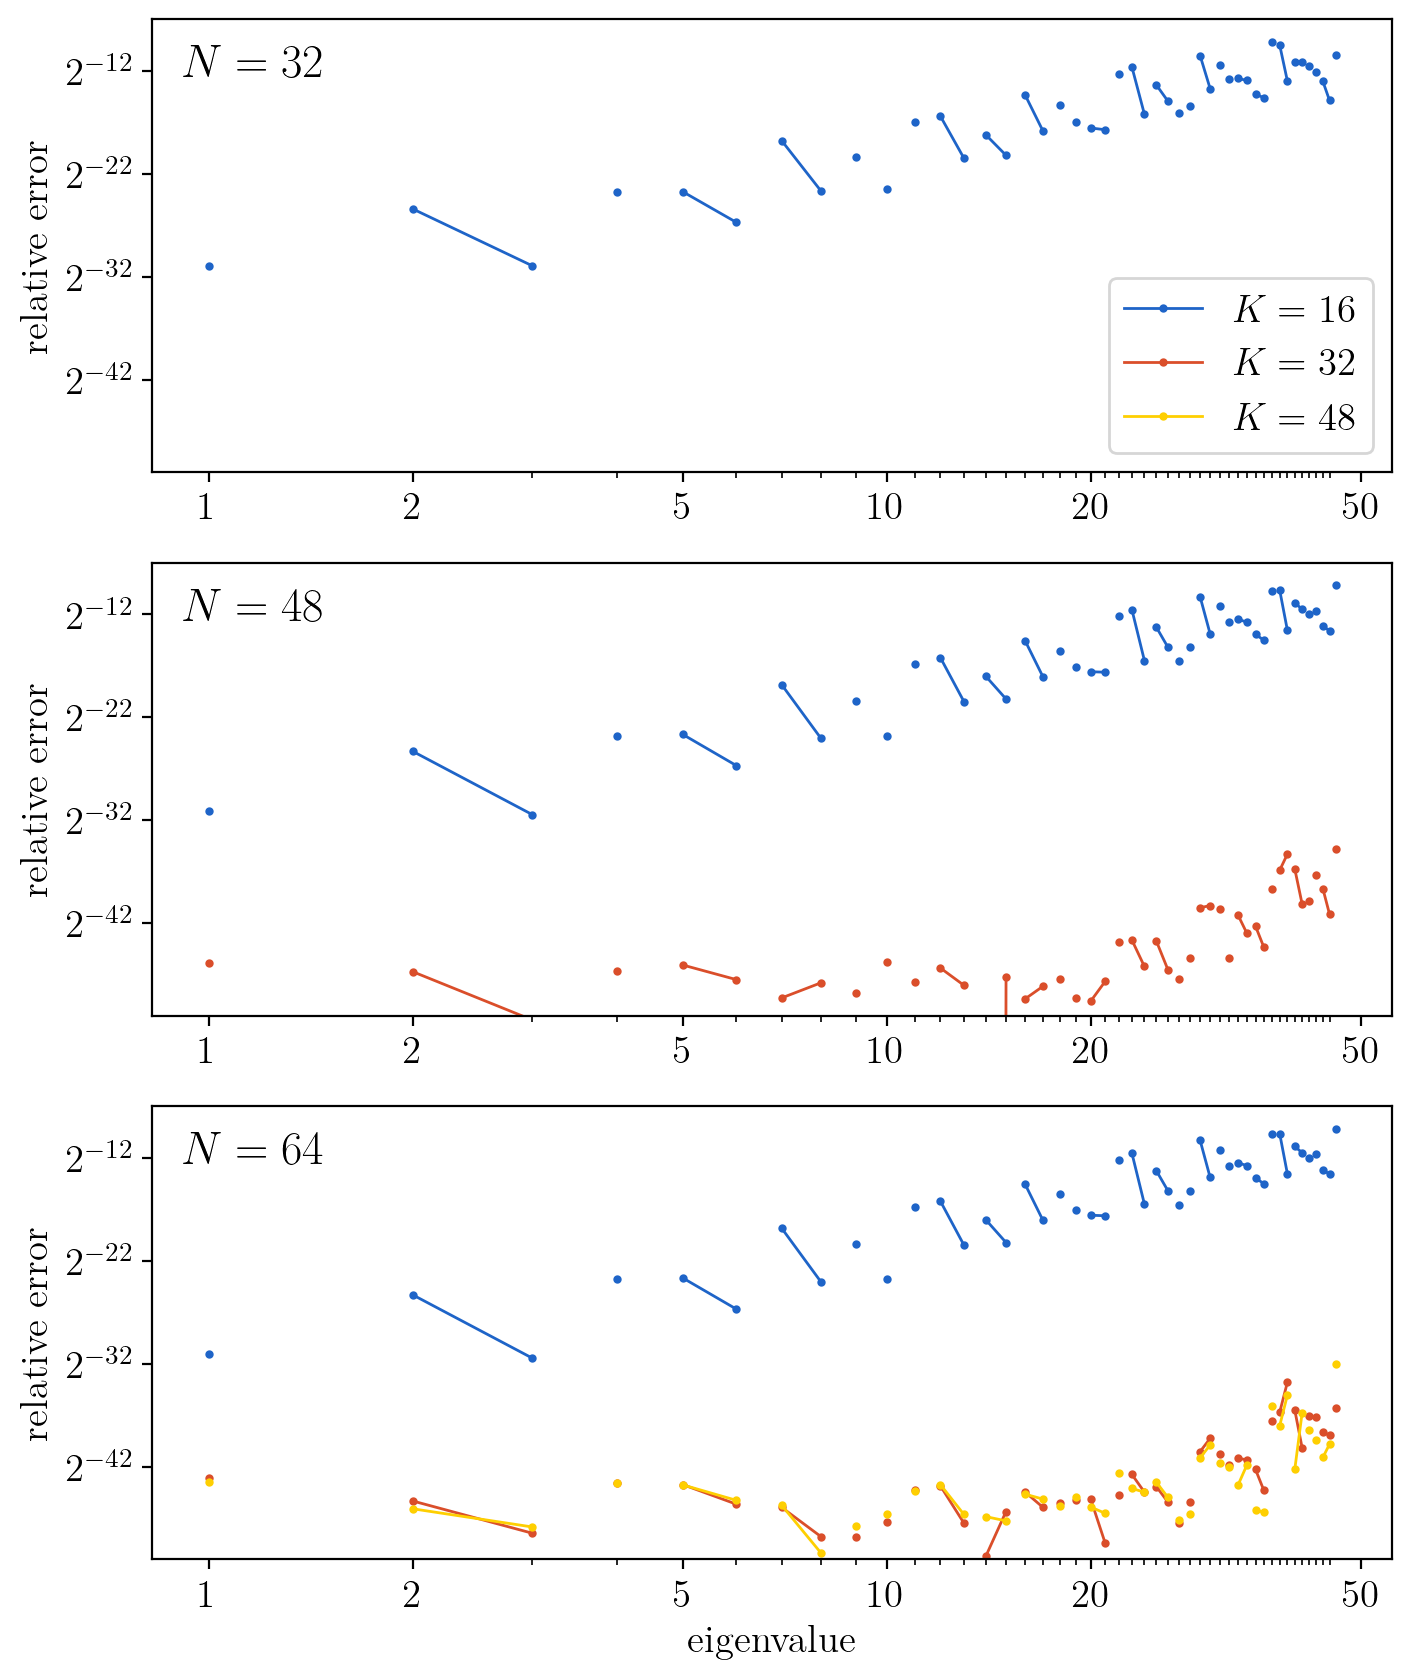

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=200)
    
for ni, n in enumerate([32, 48, 64]):
    rm = dict(results_by_n[n])
    N = len(next(iter(rm.values())))

    ax = axes[ni]
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=2)
    ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50, 100]))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
    ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
    ax.set_ylim(2**-51, 2**-7)
    ax.set_ylabel("relative error")
    if ni == 2:
        ax.set_xlabel("eigenvalue")

    mults = settings["multiplicities"]

    for i, (m, r) in enumerate(sorted(rm.items())):
        j = 0

        kwargs = dict(
            label=f"$K={m}$",
            color=ugent.palet[i],
            marker='.', ls='-', lw=1, markersize=4,
        )
        for mult in mults:
            d = r[j:j+mult]
            ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
            if j == 0:
                del kwargs["label"]
            j += mult
            if j >= len(r):
                break

    ax.set_title(f"$N = {n}$", y=0.835, x=0.025, loc="left")


axes[0].legend(*axes[2].get_legend_handles_labels(), loc="lower right")
    
fig.show()
plt.savefig(f"nm_test_henon.pdf", bbox_inches="tight")

In [ ]:
import math
from schrodinger import Circle

settings = {
    "exact": np.array([2*i for i in range(1, 30) for k in range(i)][:100]),
    "multiplicities": [i for i in range(1, 30)],
    "V": lambda x, y:  x*x + y*y,
    "domain": lambda: Circle(9.5),
    "parameters": [
        (n, m) for n in [32, 48, 64] for m in [16, 32, 48] if m // 16 <= math.ceil(n / 16)
    ]
}

results_by_n, results_by_m = test_problem(settings, shiftInvert=True)

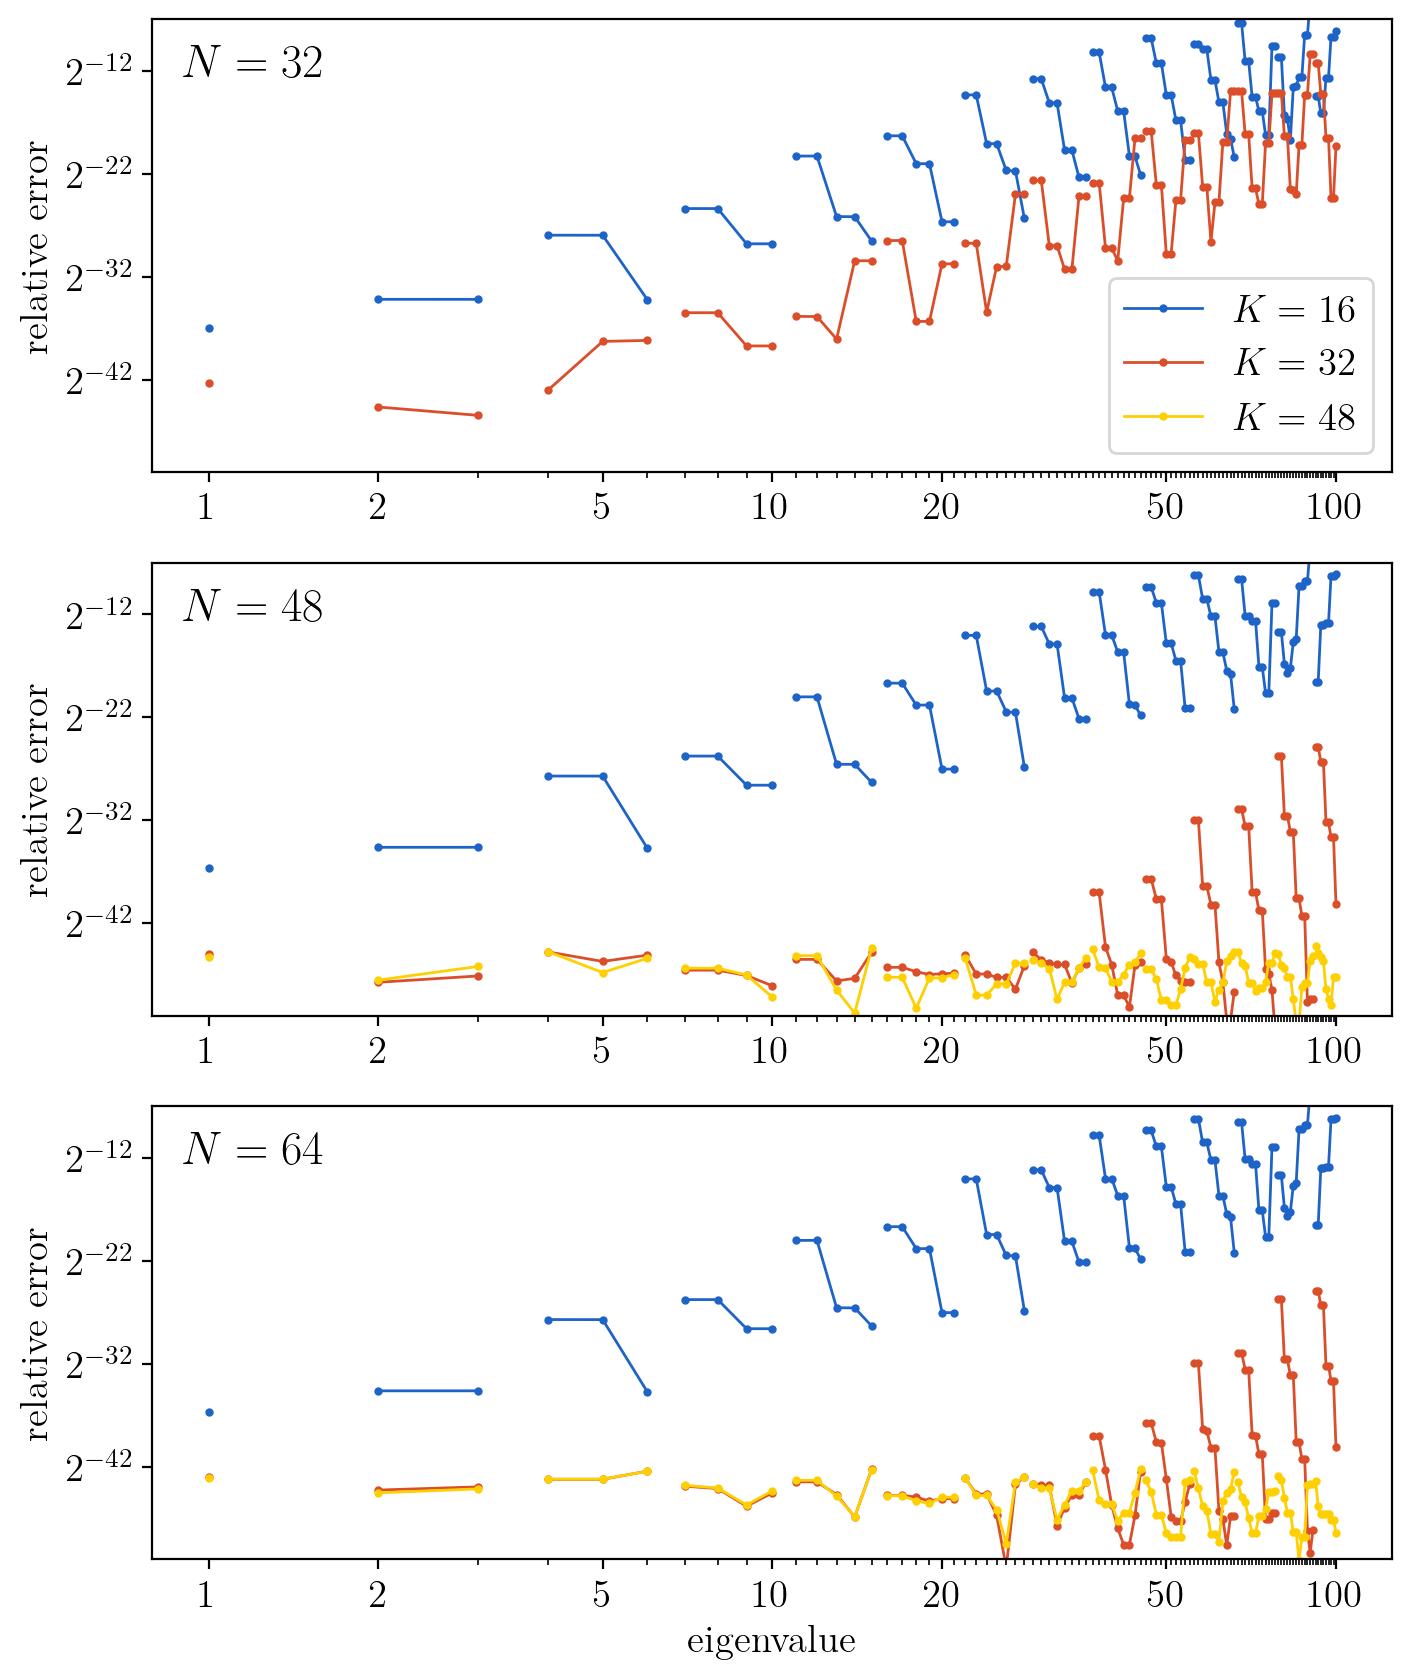

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=200)
    
for ni, n in enumerate([32, 48, 64]):
    rm = dict(results_by_n[n])
    N = len(next(iter(rm.values())))

    ax = axes[ni]
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=2)
    ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50, 100]))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
    ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
    ax.set_ylim(2**-51, 2**-7)
    ax.set_ylabel("relative error")
    if ni == 2:
        ax.set_xlabel("eigenvalue")

    mults = settings["multiplicities"]

    for i, (m, r) in enumerate(sorted(rm.items())):
        j = 0

        kwargs = dict(
            label=f"$K={m}$",
            color=ugent.palet[i],
            marker='.', ls='-', lw=1, markersize=4,
        )
        for mult in mults:
            d = r[j:j+mult]
            ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
            if j == 0:
                del kwargs["label"]
            j += mult
            if j >= len(r):
                break

    ax.set_title(f"$N = {n}$", y=0.835, x=0.025, loc="left")


axes[0].legend(*axes[2].get_legend_handles_labels(), loc="lower right")
    
fig.show()
plt.savefig(f"nm_test_harmonic_disc.pdf", bbox_inches="tight")

In [19]:
x = np.linspace(-5, 5, 311)
y = np.linspace(-5, 5, 311)
X, Y = np.meshgrid(x, y)

V = lambda x,y: x*x + y*y

def get_eigenfunctions(domain, start, end):
    s = Schrodinger2D(V, domain, gridSize=(64, 64), maxBasisSize=48)
    return tuple(zip(*s.eigenfunctions(end+5, sparse=True, shiftInvert=True)[start:end]))

def gramm_schmidt(m):
    rows, cols = m.shape
    r = np.zeros(m.shape)
    for i in range(cols):
        r[:, i] = m[:, i]
        for j in range(i):
            r[:, i] -= np.dot(r[:,j], m[:, i]) * r[:, j]
        r[:, i] /= np.linalg.norm(r[:, i])
    return r

In [20]:
import matplotlib.patches as patches

offset = 6
count = 4

zs = []
for i, (is_circle, domain) in enumerate([
    (False, Rectangle(-5,5, -5,5)),
    (True, Circle(5))
]):
    Es, fs = get_eigenfunctions(domain, offset, offset+count)
    print(Es)
    
    z = np.zeros((count,)+X.shape, dtype=np.float64)
    where = np.where(X*X + Y*Y < 5**2) if is_circle else np.where(X*X + Y*Y >= 0)
    for j, f in enumerate(fs):
        z[(j,) + where] = f(X[where], Y[where])
    zs.append(gramm_schmidt(z.reshape(count, -1).T).T.reshape(z.shape))

(8.000000175346074, 8.000000175346088, 8.000002442606027, 8.00000244260631)
(8.000003004584395, 8.000003004584777, 8.000007558030417, 8.000007558031994)


[5.54605503e-08 5.54607820e-08 1.42119758e-07 1.42119770e-07]


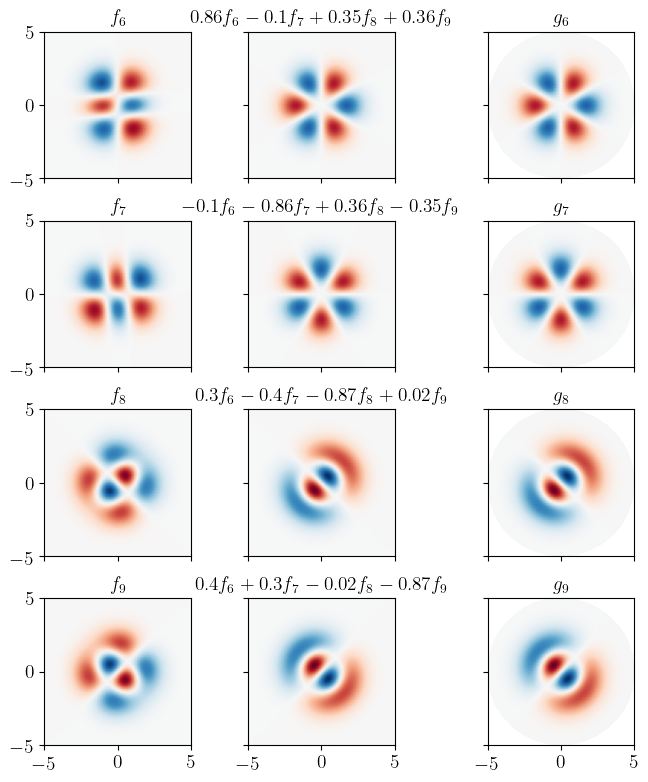

In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator

zr, zc = zs

x_small = np.linspace(-5, 5, 97)
y_small = np.linspace(-5, 5, 97)
xg_small, yg_small = np.meshgrid(x_small, y_small)

vmax = max(np.max(np.abs(z)) for z in zs)
vmin = -vmax

vr = zr.reshape(count, -1)
vc = zc.reshape(count, -1)
lstsq_x, lstsq_residual, _, _ = np.linalg.lstsq(vr.T, vc.T,rcond=None)
print(lstsq_residual)
zro = (vr.T @ lstsq_x).T.reshape(zr.shape)

labels = [[f'f_{{{i}}}' for i in range(offset, offset+count)]]
lstsq_labels = []
for col in lstsq_x.T:
    l = ''
    for i in range(count):
        v = col[i]
        f = "%.2f"%abs(v)
        if f != '0.00':
            if v < 0:
                l += ' - ' if l else '-'
            elif l:
                l += ' + '
            l += f.rstrip('0').rstrip('.')
            l += f' f_{{{offset + i}}}'
    lstsq_labels.append(l)
labels.append(lstsq_labels)
labels.append([f'g_{{{i}}}' for i in range(offset, offset+count)])

fig = plt.figure(figsize=(8,10))
gs = GridSpec(count+1, 4, figure=fig, width_ratios=(1,1,.05,1), height_ratios=(1,)*count + (0.1,), hspace=0.35)

axes = {}

for i, (z_labels, is_circle, z) in list(enumerate(zip(labels, [False, False, True], [zr, zro, zc]))):
    for j, label in list(enumerate(z_labels))[::-1]:
        share = {}
        if i > 0:
            share["sharex"] = axes[(j, 0)]
        if j < count - 1:
            share["sharey"] = axes[(count - 1, i)]
        ax = fig.add_subplot(gs[j, i if i < 2 else i + 1], **share)
        if i > 0:
            ax.set_yticklabels([], visible=False)
        if j < count - 1:
            ax.set_xticklabels([], visible=False)
        axes[(j, i)] = ax
        ax.set_title('$'+label+'$', size=14)
        ax.set_aspect(1)
        ax.set_xticks(ticks=[-5,0,5])
        ax.set_yticks(ticks=[-5,0,5])
        
        interp = RegularGridInterpolator((x, y), z[j,:,:])
        
        mesh = ax.pcolormesh(x_small, y_small, interp((xg_small, yg_small)), shading='gouraud', vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu)
        if is_circle:
            mesh.set_clip_path(patches.Circle((0,0), 5, transform=ax.transData))
            
if False:
    ax_r_title = fig.add_subplot(gs[-1,:2])
    ax_r_title.set_title(r"$\Omega = [-5, 5]\times[-5, 5]$", size=14, y=0)
    ax_r_title.set_axis_off()

    ax_r_title = fig.add_subplot(gs[-1, 3])
    ax_r_title.set_title(r"$\Omega = B(\vb{0}, 5)$", size=14, y=0)
    ax_r_title.set_axis_off()
plt.savefig("nm_test_harmonic_eigenfunctions.png", bbox_inches='tight', dpi=500)